## Random Forest Model

### Imports and Utils

In [1]:
"""
Importing the necessary libraries
"""
import os
from time import time
import pickle
from typing import Union

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import xlogy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

try:
    import plotly.express as px
except ModuleNotFoundError:
    %pip install plotly
    import plotly.express as px

try:
    from ucimlrepo import fetch_ucirepo
except ModuleNotFoundError:
    %pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Metric functions for the Model
"""

def accuracy(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels

    Returns: float: Accuracy
    """

    assert y_pred.size == y_true.size
    accuracy = np.isclose(y_true.values, y_pred.values, atol=0.01).mean()
    return accuracy

def Precision(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate precision for

    Returns: float: Precision
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    fp = ((np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return precision

def Recall(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate recall for

    Returns: float: Recall
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    fn = (~(np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return recall

def F1_Score(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate F1 score for

    Returns: float: F1 score
    """

    assert y_pred.shape == y_true.shape
    prec = Precision(y_true, y_pred, cls)
    rec = Recall(y_true, y_pred, cls)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    return f1

def MCC(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate Matthews Correlation Coefficient for

    Returns: float: Matthews Correlation Coefficient
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    tn = (~(np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    fp = ((np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    fn = (~(np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()

    mcc_n = (tp * tn) - (fp * fn)
    mcc_d = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    mcc = mcc_n / mcc_d if mcc_d > 0 else 0
    return mcc

In [3]:
"""
Utility functions for the Model
"""

def entropy(Y: pd.Series, bins: int = 50) -> float:
    """
    Y: pd.Series: Output values

    Returns: float: Entropy
    """

    if Y.empty:
        return 0

    # Y = pd.cut(Y, bins=bins)
    vals = Y.value_counts(normalize=True)
    return -np.sum(xlogy(vals, vals))

def gini_index(Y: pd.Series, bins: int = 50) -> float:
    """
    Y: pd.Series: Output values

    Returns: float: Gini Index
    """

    if Y.empty:
        return 0

    # Y = pd.cut(Y, bins=bins)
    vals = Y.value_counts(normalize=True)
    return 1 - np.sum(np.square(vals))

def information_gain(parent: pd.Series, left: pd.Series, right: pd.Series, criterion: str) -> float:
    """
    parent: pd.Series: Input parent dataset.
    left: pd.Series: Subset of the parent dataset.
    right: pd.Series: Subset of the parent dataset.

    Returns: float: Information gain.
    """
    FMap = {"entropy": entropy, "gini": gini_index}

    # calculate parent and child entropy
    before_entropy = FMap[criterion](parent)
    after_entropy = (len(left) / len(parent)) * FMap[criterion](left) + (len(right) / len(parent)) * FMap[criterion](right)
        
    # calculate information gain 
    information_gain = before_entropy - after_entropy
    return information_gain

def best_split(dataset: pd.DataFrame, num_samples: int, num_features: int, criterion: str) -> dict:
    """
    dataset: pd.DataFrame: The dataset to split.
    num_samples: int: The number of samples in the dataset.
    num_features: int: The number of features in the dataset.

    Returns: dict: A dictionary with the best split.
    """
        
    # Find the best split
    best_split = {'gain': -1, 'feature': None, 'threshold': None, "left_dataset": None, "right_dataset": None}
    for feature_index in range(num_features):
        feature_values = dataset.iloc[:, feature_index]
        thresholds = np.unique(feature_values)
        for threshold in thresholds:
            left_dataset, right_dataset = split_data(dataset, feature_index, threshold)
            y, left_y, right_y = dataset.iloc[:, -1], left_dataset.iloc[:, -1], right_dataset.iloc[:, -1]
            gain = information_gain(y, left_y, right_y, criterion)
            if gain > best_split["gain"]:
                best_split["gain"] = gain
                best_split["feature"] = feature_index
                best_split["threshold"] = threshold
                best_split["left_dataset"] = left_dataset
                best_split["right_dataset"] = right_dataset
    return best_split

def split_data(dataset: pd.DataFrame, feature: int, threshold: float) -> tuple:
    """
    dataset: pd.DataFrame: Input dataset.
    feature: int: Index of the feature to be split on.
    threshold: float: Threshold value to split the feature on.

    Returns:
        left_dataset: pd.DataFrame: Subset of the dataset.
        right_dataset: pd.DataFrame: Subset of the dataset.
    """
    
    # Create mask of the dataset using threshold
    mask = (dataset.iloc[:, feature] <= threshold)

    # Mask the dataset
    left_dataset = dataset[mask]
    right_dataset = dataset[~mask]
    return left_dataset, right_dataset

def bootstrapping(dataset: pd.DataFrame):
    """
    dataset: pd.DataFrame: Input dataset.

    Returns:
        dataset: pd.DataFrame: Bootstrapped dataset.
    """

    # np.random.seed(42)
    n_samples = dataset.shape[0]

    indices = np.random.choice(n_samples, n_samples, replace=True)
    return dataset.iloc[indices]

In [4]:
# Plotting the metrics
def plot_metrics(Metrics: pd.DataFrame, type: str, title: str):
    """
    Metrics: pd.DataFrame: Metrics computed of the model.
    type: string: The type of the decision tree.
    title: string: X-axis of the plots.
    """
        
    if type == 'classification':
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        Metrics.iloc[:, :2].plot(ax=axs[0, 0])
        axs[0, 0].set_xlabel(f'{title} of the Random Forest')
        axs[0, 0].set_ylabel('Mean Squared Error')
        axs[0, 0].set_title(f'Mean Squared Error vs {title} of Random Forest')

        Metrics.iloc[:, 2:4].plot(ax=axs[0, 1])
        axs[0, 1].set_xlabel(f'{title} of the Random Forest')
        axs[0, 1].set_ylabel('Time Taken (s)')
        axs[0, 1].set_title(f'Time Taken vs {title} of Random Forest')

        Metrics.iloc[:, 4:6].plot(ax=axs[1, 0])
        axs[1, 0].set_xlabel(f'{title} of the Random Forest')
        axs[1, 0].set_ylabel('Accuracy')
        axs[1, 0].set_title(f'Accuracy vs {title} of Random Forest')

        Metrics.iloc[:, 6:].plot(ax=axs[1, 1])
        axs[1, 1].set_xlabel(f'{title} of the Random Forest')
        axs[1, 1].set_ylabel('Scores')
        axs[1, 1].set_title(f'Scores vs {title} of Random Forest')

    elif type == 'regression':
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))

        Metrics.iloc[:, :2].plot(ax=axs[0])
        axs[0].set_xlabel(f'{title} of the Random Forest')
        axs[0].set_ylabel('Mean Squared Error')
        axs[0].set_title(f'Mean Squared Error vs {title} of Random Forest')

        Metrics.iloc[:, 2:].plot(ax=axs[1])
        axs[1].set_xlabel(f'{title} of the Random Forest')
        axs[1].set_ylabel('Time Taken (s)')
        axs[1].set_title(f'Time Taken vs {title} of Random Forest')
        
    plt.tight_layout()
    plt.show()

### Dataset Loading and Preprocessing

In [5]:
target = 'Classes  '

# Dataset 1 Auto MPG
'''
# Reading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
dataset = pd.read_csv(url, delim_whitespace=True, header=None,names=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"])

# Cleaning the data
dataset = dataset.drop(columns=["car name", "origin"]).replace('?', np.nan).dropna()
dataset['horsepower'] = pd.to_numeric(dataset['horsepower'])
dataset = pd.concat([dataset.drop(columns=[target]), dataset[target]], axis=1)

# Print the first few records
print(dataset.head())

# Print the size of the dataset
print("size of the dataset: ", dataset.shape)
'''

# Dataset 2 Algerian Forest Fires
# '''
dataset = fetch_ucirepo(id=547)
dataset = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

# Cleaning the data
dataset = dataset.dropna()
dataset = dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)
dataset[target] = (dataset[target] == 'fire').astype(int)
dataset = pd.get_dummies(dataset, columns=['region']).astype(float)
dataset = pd.concat([dataset.drop(columns=[target]), dataset[target]], axis=1)

# Print the first few records
print(dataset.head())

# Print the size of the dataset
print("size of the dataset: ", dataset.shape)
# '''

   day  month    year  Temperature    RH    Ws  Rain   FFMC  DMC    DC  ISI  \
0  1.0    6.0  2012.0         29.0  57.0  18.0    0.0  65.7  3.4   7.6  1.3   
1  2.0    6.0  2012.0         29.0  61.0  13.0    1.3  64.4  4.1   7.6  1.0   
2  3.0    6.0  2012.0         26.0  82.0  22.0   13.1  47.1  2.5   7.1  0.3   
3  4.0    6.0  2012.0         25.0  89.0  13.0    2.5  28.6  1.3   6.9  0.0   
4  5.0    6.0  2012.0         27.0  77.0  16.0    0.0  64.8  3.0  14.2  1.2   

   BUI  FWI  region_Bejaia  region_Sidi-Bel Abbes  Classes    
0  3.4  0.5            1.0                    0.0        0.0  
1  3.9  0.4            1.0                    0.0        0.0  
2  2.7  0.1            1.0                    0.0        0.0  
3  1.7  0.0            1.0                    0.0        0.0  
4  3.9  0.5            1.0                    0.0        0.0  
size of the dataset:  (243, 16)


In [6]:
# Data visualization
px.pie(dataset, target, color=target, color_discrete_sequence=["#ba1656","#381a40"], title='Data Distribution')

In [7]:
for column in dataset.drop(target,axis=1).columns[:5]:
    fig = px.density_heatmap(dataset, x=column, y=target, color_continuous_scale='magma_r')
    fig.show()

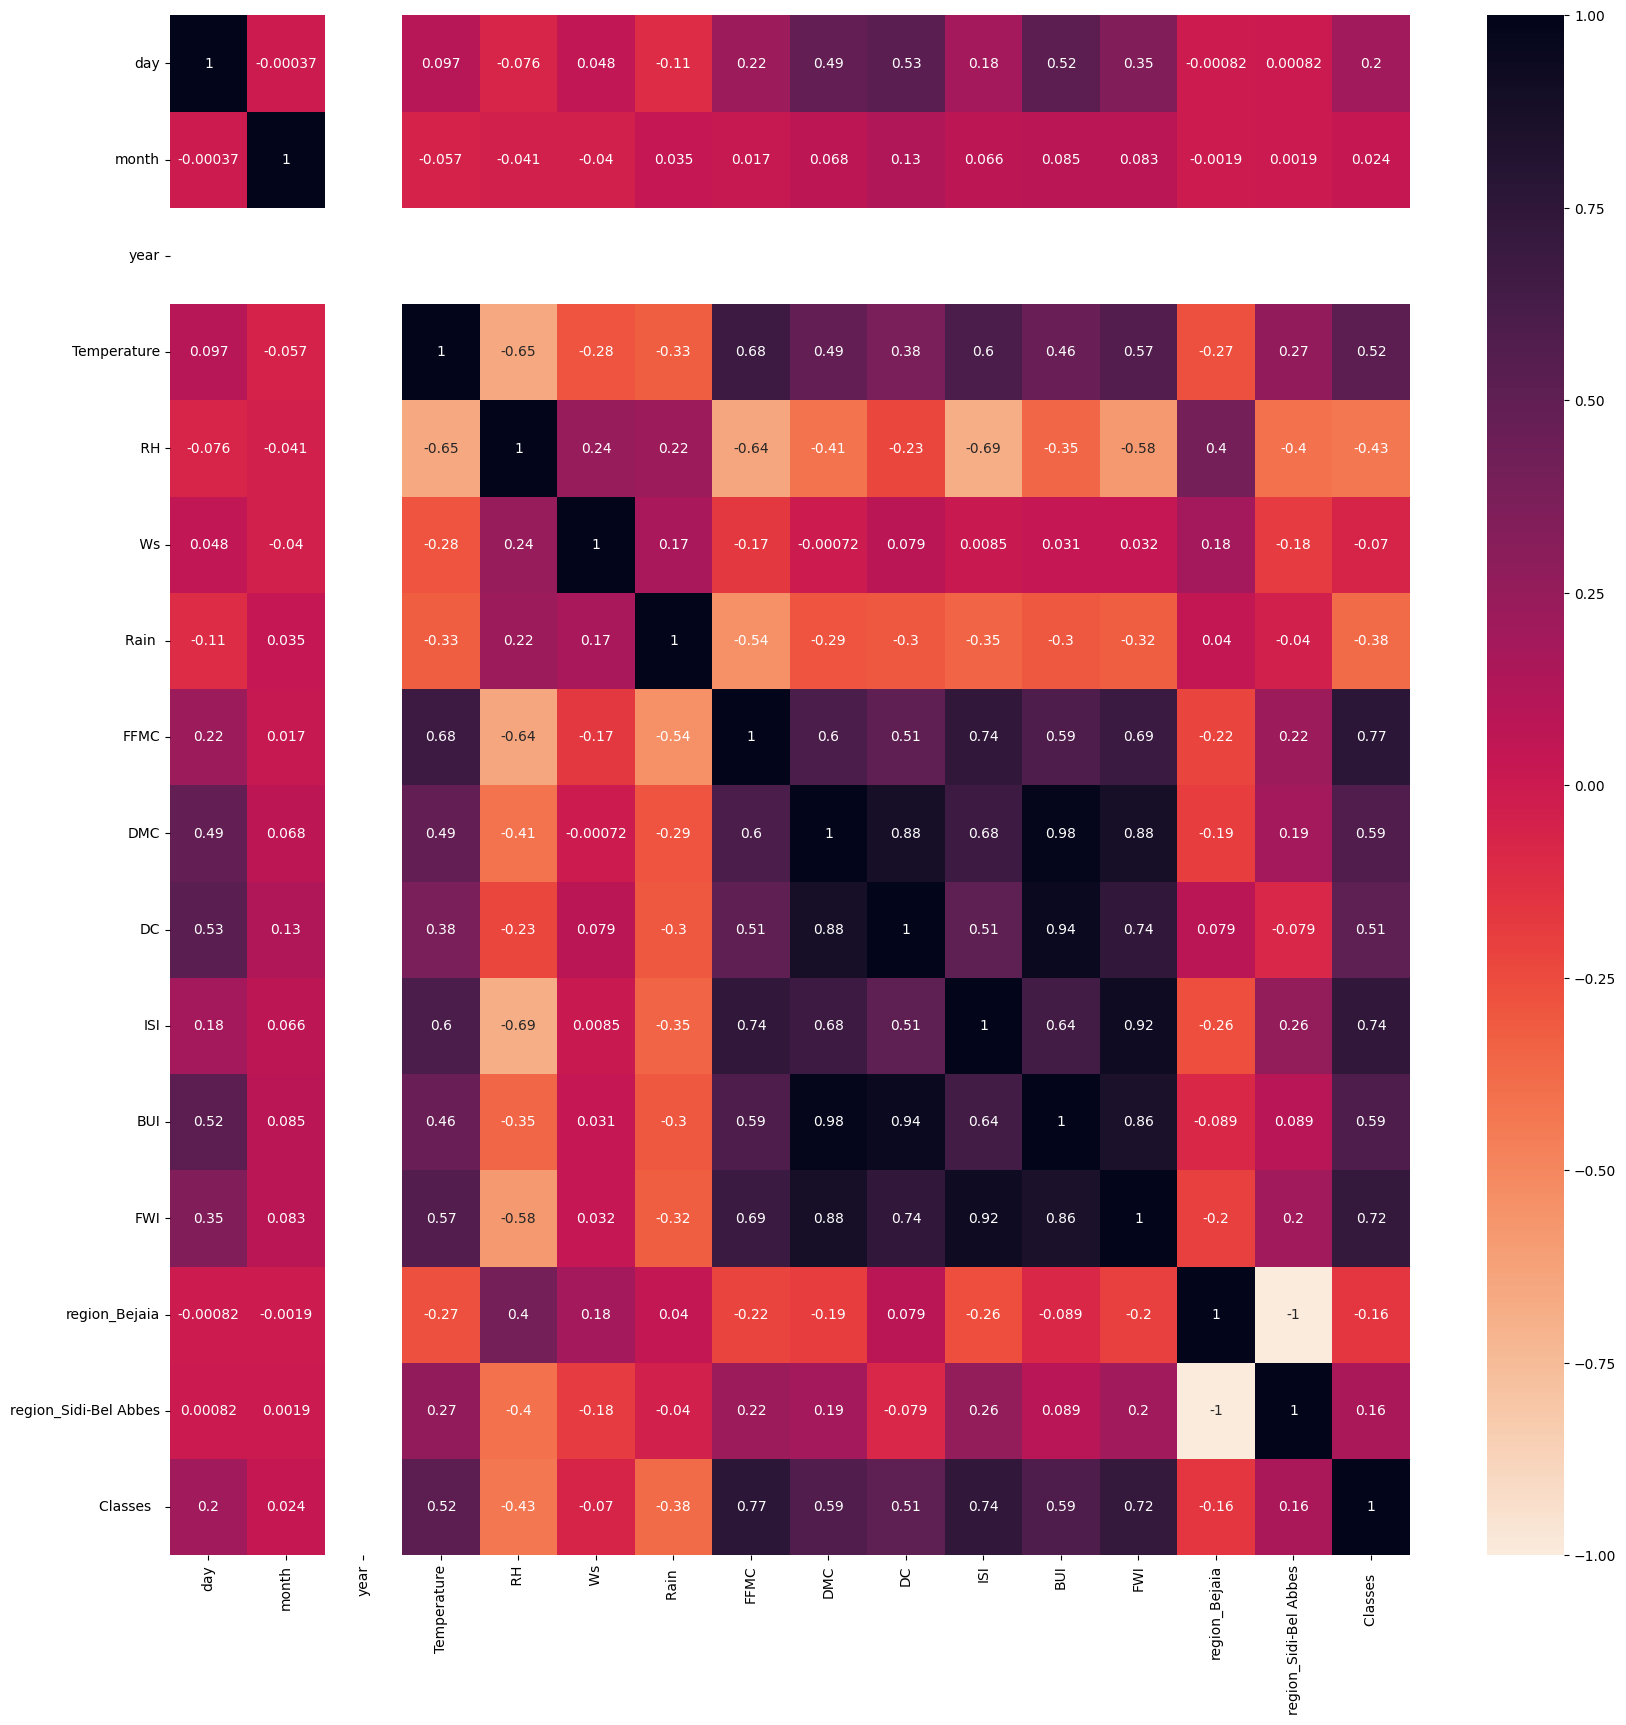

In [8]:
# Checking coorelation within the dataset
dataset_corr = dataset.corr()
plt.figure(figsize=(20,20))
sns.heatmap(dataset_corr, cmap='rocket_r',annot=True)
plt.show()

In [9]:
# Feature selection
threshold = 0.35
target_corr = abs(dataset_corr.iloc[:, -1])
features = target_corr[target_corr > threshold].index

# Display the relevant features
dataset = dataset[features]
print("Relevant Features:\n", features.values)

Relevant Features:
 ['Temperature' ' RH' 'Rain ' 'FFMC' 'DMC' 'DC' 'ISI' 'BUI' 'FWI'
 'Classes  ']


In [10]:
# Extract X and Y from dataset
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:, -1]

# Split the dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

# Print the first few records
print(f'Feature Train Dataset:\n{X_train.head()}\nsize: {X_train.shape}\n')
print(f'Target Train Dataset:\n{Y_train.head()}\nsize: {Y_train.shape}\n')
print(f'Feature Test Dataset:\n{X_test.head()}\nsize: {X_test.shape}\n')
print(f'Target Test Dataset:\n{Y_test.head()}\nsize: {Y_test.shape}\n')

Feature Train Dataset:
     Temperature    RH  Rain   FFMC   DMC     DC   ISI   BUI   FWI
115         29.0  65.0    0.6  68.3   5.5   15.2   1.5   5.8   0.7
208         33.0  37.0    0.0  92.2  61.3  167.2  13.1  64.0  30.3
158         38.0  43.0    0.5  85.0  13.0   35.4   4.1  13.7   5.2
132         31.0  42.0    0.0  90.6  18.2   30.5  13.4  18.0  16.7
84          34.0  64.0    0.0  88.9  40.5  171.3   9.0  50.9  20.9
size: (194, 9)

Target Train Dataset:
115    0.0
208    1.0
158    1.0
132    1.0
84     1.0
Name: Classes  , dtype: float64
size: (194,)

Feature Test Dataset:
     Temperature    RH  Rain   FFMC   DMC    DC  ISI   BUI  FWI
24          31.0  64.0    0.0  86.7  14.2  63.8  5.7  18.3  8.4
6           33.0  54.0    0.0  88.2   9.9  30.5  6.4  10.9  7.2
152         28.0  58.0    2.2  63.7   3.2   8.5  1.2   3.3  0.5
233         34.0  58.0    0.2  79.5  18.7  88.0  2.1  24.4  3.8
239         30.0  65.0    0.0  85.4  16.0  44.5  4.5  16.9  6.5
size: (49, 9)

Target Test Dat

### Model Creation and Training

In [11]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        feature: string: The feature used for splitting at this node.
        threshold: List of float: The threshold used for splitting at this node.
        left: Node: Pointer to the left Node.
        Right: Node: Pointer to the Right Node.
        gain: float: The gain of the split.
        value: float: predicted value at this node.
        """

        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

In [12]:
class DecisionTree():
    """
    A decision tree classifier/regressor.
    """

    def __init__(self, type: str, criterion: str = 'entropy', min_samples: int = 2, max_depth: int = 2):
        """
        Constructor for DecisionTree class.

        type: string: The type of the decision tree.
        criterion: string: The criterion used to split nodes.
        min_samples: int: Minimum number of samples at leaf node.
        max_depth: int: Maximum depth of the decision tree.
        """

        if type not in ["classification", "regression"]:
            raise ValueError("type should be either 'classification' or 'regression'")
        
        if criterion not in ["entropy", "gini"]:
            raise ValueError("criterion should be either 'entropy' or 'gini'")
        
        self.type = type
        self.criterion = criterion
        self.min_samples = min_samples
        self.max_depth = max_depth
    
    def build_tree(self, dataset: pd.DataFrame, current_depth: int = 0) -> Node:
        """
        dataset: pd.DataFrame: The dataset to build the tree.
        current_depth: int: The current depth of the tree.

        Returns: Node: The root node of the decision tree.
        """
        
        # split the dataset into X, y values
        X, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
        n_samples, n_features = X.shape
        
        # Terminating conditions
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            best_split_values = best_split(dataset, n_samples, n_features, self.criterion)
            left_node = self.build_tree(best_split_values["left_dataset"], current_depth + 1)
            right_node = self.build_tree(best_split_values["right_dataset"], current_depth + 1)

            return Node(best_split_values["feature"], best_split_values["threshold"], left_node, right_node, best_split_values["gain"])

        # compute leaf node value
        if self.type == "classification":
            leaf_value = -1 if y.empty else y.mode()[0]
        elif self.type == "regression":
            leaf_value = -1 if y.empty else y.median()
        
        return Node(value=leaf_value)
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        X: pd.DataFrame: The feature datset.
        y: pd.Series: The target values.
        """
        
        dataset = pd.concat([X, y], axis=1) 
        self.root = self.build_tree(dataset)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """
        X: pd.DataFrame: The feature matrix to make predictions for.

        Returns:
            predictions: pd.Series: A Series of predicted class labels.
        """
        
        predictions = X.apply(self.traverse_tree, axis=1, args=(self.root,))
        return predictions
    
    def traverse_tree(self, X: pd.Series, node: Node) -> float:
        """
        X: pd.Series: The feature vector to predict the target value for.
        node: Node: The current node being evaluated.

        Returns: float: The predicted target value.
        """
        
        if node.value is not None: # if the node is a leaf node
            return node.value
        else: # if the node is not a leaf node
            feature = X.iloc[node.feature]
            if feature <= node.threshold:
                return self.traverse_tree(X, node.left)
            else:
                return self.traverse_tree(X, node.right)
            
    def plot_tree(self, node: Node = None, depth: int = 0):
        """
        Plot the decision tree.

        node: Node: The current node being evaluated.
        depth: int: The current depth of the tree.
        """
        
        if node is None:
            node = self.root

        if node.value is not None:
            print(f"{4*depth * '  '}Predict: {round(node.value, 3)}")
        else:
            print(f"{4*depth * '  '}?(column {node.feature} <= {round(node.threshold, 3)})")
            self.plot_tree(node.left, depth + 1)
            self.plot_tree(node.right, depth + 1)

In [13]:
class RandomForest():
    """
    A decision tree classifier/regressor.
    """

    def __init__(self, type: str, criterion: str = 'entropy', n_trees: int = 2, min_samples: int = 2, max_depth: int = 2):
        """
        Constructor for RandomForest class.

        type: string: The type of the decision tree.
        criterion: string: The criterion used to split nodes.
        n_trees: int: Number of trees in random forest.
        min_samples: int: Minimum number of samples at leaf node.
        max_depth: int: Maximum depth of the decision tree.
        """

        if type not in ["classification", "regression"]:
            raise ValueError("type should be either 'classification' or 'regression'")
        
        if criterion not in ["entropy", "gini"]:
            raise ValueError("criterion should be either 'entropy' or 'gini'")
        
        self.type = type
        self.criterion = criterion
        self.n_trees = n_trees
        self.trees = []
        self.min_samples = min_samples
        self.max_depth = max_depth

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        X: pd.DataFrame: The feature datset.
        y: pd.Series: The target values.
        """
        
        dataset = pd.concat([X, y], axis=1)

        for _ in range(self.n_trees):
            tree = DecisionTree(type=self.type, criterion=self.criterion, min_samples=self.min_samples, max_depth=self.max_depth)

            dataset_bootstrap = bootstrapping(dataset)
            X, y = dataset_bootstrap.iloc[:, :-1], dataset_bootstrap.iloc[:, -1]

            tree.fit(X, y)
            self.trees.append(tree)

    def predict(self, X: pd.DataFrame):
        """
        X: pd.DataFrame: The feature matrix to make predictions for.

        Returns:
            predictions: pd.Series: A Series of predicted class labels.
        """
        
        predictions = np.array([tree.predict(X) for tree in self.trees])
        
        if self.type == 'classification':
            predictions = stats.mode(predictions, axis=0)[0]
        else:
            predictions = np.mean(predictions, axis=0)

        return pd.Series(predictions.reshape(-1))
    
    def plot_forest(self, n_plot: int = None):
        """
        Plot the random forest.
        n_plot: int: The number of trees to plot.
        """

        if n_plot == None:
            n_plot = len(self.trees)
        else:
            n_plot = min(n_plot, len(self.trees))

        for i in range(n_plot):
            print(f"Decision Tree {i}\n")
            self.trees[i].plot_tree()
            print("\n------------------------------------------------------------\n")

In [14]:
# Defining the model for Random Forest
# model = RandomForest(type='regression', criterion='entropy', n_trees=1 , min_samples=10, max_depth=3)
model = RandomForest(type='classification', criterion='entropy', n_trees=3 , min_samples=10, max_depth=3)

In [15]:
# Training the model
model.fit(X_train, Y_train)

# Calculating the metrics
Y_pred = model.predict(X_train)
print(f"Train MSE: {mean_squared_error(Y_train, Y_pred)}")

Train MSE: 0.015463917525773196


In [16]:
# Plotting the Random Forest
model.plot_forest()

Decision Tree 0

?(column 3 <= 81.8)
        ?(column 5 <= 79.9)
                ?(column 0 <= 22.0)
                        Predict: 0.0
                        ?(column 0 <= 24.0)
                                Predict: 0.0
                                Predict: 0.0
                Predict: 1.0
        ?(column 0 <= 26.0)
                Predict: 1.0
                ?(column 0 <= 27.0)
                        Predict: 1.0
                        ?(column 0 <= 28.0)
                                Predict: 1.0
                                Predict: 1.0

------------------------------------------------------------

Decision Tree 1

?(column 3 <= 79.9)
        ?(column 0 <= 22.0)
                Predict: 0.0
                ?(column 0 <= 24.0)
                        Predict: 0.0
                        ?(column 0 <= 25.0)
                                Predict: 0.0
                                Predict: 0.0
        ?(column 8 <= 3.4)
                Predict: 1.0
               

### Testing and Plotting

In [17]:
# Predicting the values
Y_pred = model.predict(X_test)

# Calculating the metrics
print(f'Test MSE: {mean_squared_error(Y_test, Y_pred)}')

Test MSE: 0.04081632653061224


In [18]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
type = 'classification'
n_classes = np.unique(Y_test)
Metrics = {}
for depth in range(0, 5):
    print(f"Random Forest for max depth of {depth}")

    # Defining the model for Decision Tree
    model = RandomForest(type=type, criterion='entropy', n_trees=3, min_samples=10, max_depth=depth)
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, Y_pred)
    if type == 'classification':
        accuracy_train = accuracy(Y_train, Y_pred)
        print(f"Train Accuracy: {round(100*accuracy_train, 3)}")
    start = time()
    Y_pred = model.predict(X_test)
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test, Y_pred)
    if type == 'classification':
        accuracy_test = accuracy(Y_test, Y_pred)
        f1score = 0
        mcc = 0
        for i in range(len(n_classes)):
            f1score += F1_Score(Y_test, Y_pred, n_classes[i])
            mcc += MCC(Y_test, Y_pred, n_classes[i])
        f1score /= len(n_classes)
        mcc /= len(n_classes)
        print(f"Test Accuracy: {round(100*accuracy_test, 3)}")
        print(f"F1 Score: {round(f1score, 3)}")
        print(f"Matthews Correlation Coefficient: {round(mcc, 3)}")

    # Storing the metrics
    Metrics[depth] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    print(f"Train MSE: {round(train_mse, 3)}")
    print(f"Test MSE: {round(test_mse, 3)}")
    if type == 'classification':
        Metrics[depth]["Train Accuracy"] = accuracy_train
        Metrics[depth]["Test Accuracy"] = accuracy_test
        Metrics[depth]["F1 Score"] = f1score
        Metrics[depth]["MCC"] = mcc

    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T


Random Forest for max depth of 0
Train Accuracy: 98.454
Test Accuracy: 95.918
F1 Score: 0.958
Matthews Correlation Coefficient: 0.92
Train MSE: 0.015
Test MSE: 0.041

------------------------------------------------------------

Random Forest for max depth of 1
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------

Random Forest for max depth of 2
Train Accuracy: 97.423
Test Accuracy: 95.918
F1 Score: 0.959
Matthews Correlation Coefficient: 0.918
Train MSE: 0.026
Test MSE: 0.041

------------------------------------------------------------

Random Forest for max depth of 3
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------

Random Forest for max depth of 4
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Scor

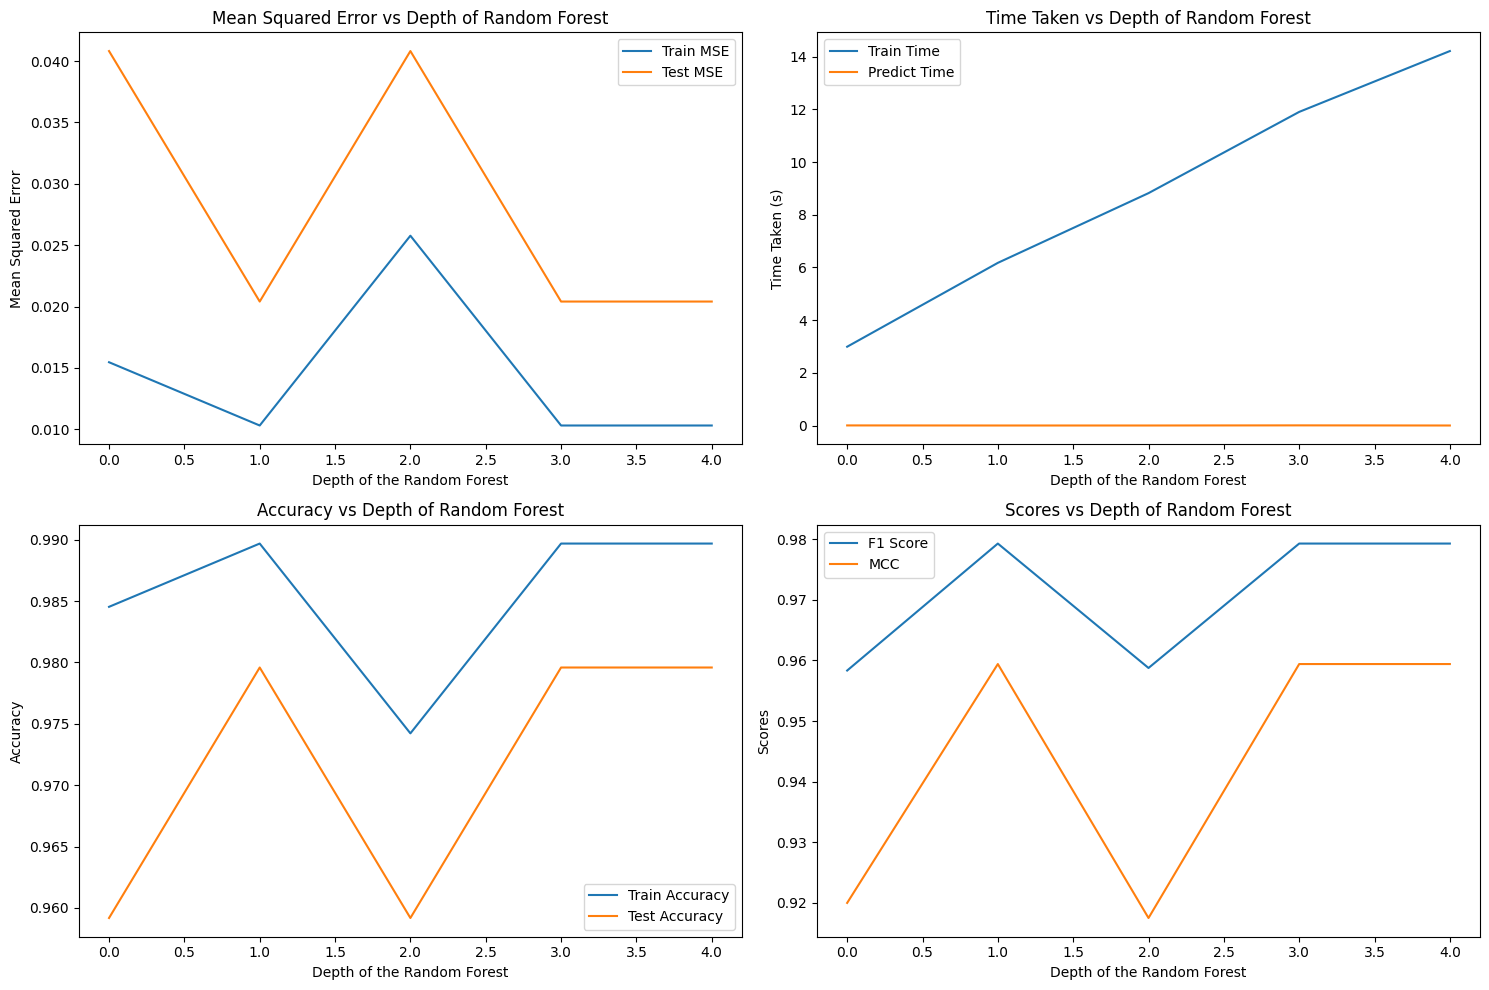

In [19]:
# Plotting the metrics
plot_metrics(Metrics, type, 'Depth')

In [20]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
type = 'classification'
n_classes = np.unique(Y_test)
Metrics = {}
for depth in range(0, 5):
    print(f"Random Forest for max depth of {depth}")

    # Defining the model for Decision Tree
    model = RandomForest(type=type, criterion='gini', n_trees=3, min_samples=10, max_depth=depth)
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, Y_pred)
    if type == 'classification':
        accuracy_train = accuracy(Y_train, Y_pred)
        print(f"Train Accuracy: {round(100*accuracy_train, 3)}")
    start = time()
    Y_pred = model.predict(X_test)
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test, Y_pred)
    if type == 'classification':
        accuracy_test = accuracy(Y_test, Y_pred)
        f1score = 0
        mcc = 0
        for i in range(len(n_classes)):
            f1score += F1_Score(Y_test, Y_pred, n_classes[i])
            mcc += MCC(Y_test, Y_pred, n_classes[i])
        f1score /= len(n_classes)
        mcc /= len(n_classes)
        print(f"Test Accuracy: {round(100*accuracy_test, 3)}")
        print(f"F1 Score: {round(f1score, 3)}")
        print(f"Matthews Correlation Coefficient: {round(mcc, 3)}")

    # Storing the metrics
    Metrics[depth] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    print(f"Train MSE: {round(train_mse, 3)}")
    print(f"Test MSE: {round(test_mse, 3)}")
    if type == 'classification':
        Metrics[depth]["Train Accuracy"] = accuracy_train
        Metrics[depth]["Test Accuracy"] = accuracy_test
        Metrics[depth]["F1 Score"] = f1score
        Metrics[depth]["MCC"] = mcc

    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T


Random Forest for max depth of 0
Train Accuracy: 98.454
Test Accuracy: 95.918
F1 Score: 0.958
Matthews Correlation Coefficient: 0.92
Train MSE: 0.015
Test MSE: 0.041

------------------------------------------------------------

Random Forest for max depth of 1
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------

Random Forest for max depth of 2
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------

Random Forest for max depth of 3
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------

Random Forest for max depth of 4
Train Accuracy: 99.485
Test Accuracy: 97.959
F1 Score:

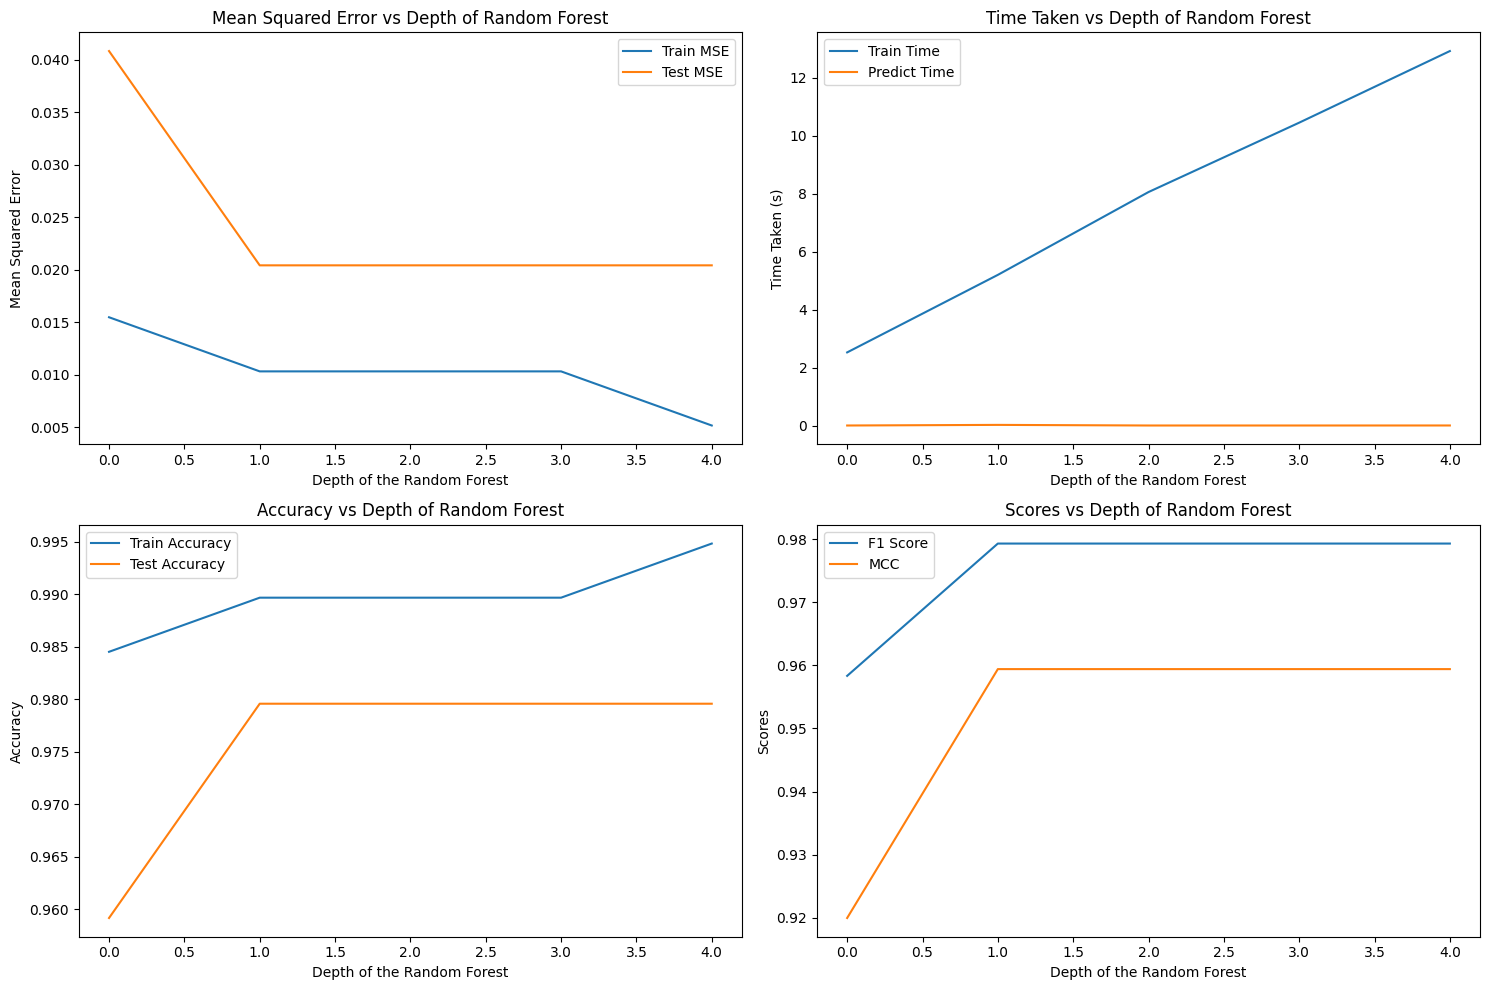

In [21]:
# Plotting the metrics
plot_metrics(Metrics, type, 'Depth')

In [22]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
type = 'classification'
n_classes = np.unique(Y_test)
Metrics = {}
for n_trees in range(1, 5):
    print(f"Random Forest of {n_trees} trees")

    # Defining the model for Decision Tree
    model = RandomForest(type=type, criterion='entropy', n_trees=n_trees, min_samples=10, max_depth=5)
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, Y_pred)
    if type == 'classification':
        accuracy_train = accuracy(Y_train, Y_pred)
        print(f"Train Accuracy: {round(100*accuracy_train, 3)}")
    start = time()
    Y_pred = model.predict(X_test)
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test, Y_pred)
    if type == 'classification':
        accuracy_test = accuracy(Y_test, Y_pred)
        f1score = 0
        mcc = 0
        for i in range(len(n_classes)):
            f1score += F1_Score(Y_test, Y_pred, n_classes[i])
            mcc += MCC(Y_test, Y_pred, n_classes[i])
        f1score /= len(n_classes)
        mcc /= len(n_classes)
        print(f"Test Accuracy: {round(100*accuracy_test, 3)}")
        print(f"F1 Score: {round(f1score, 3)}")
        print(f"Matthews Correlation Coefficient: {round(mcc, 3)}")

    # Storing the metrics
    Metrics[n_trees] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    print(f"Train MSE: {round(train_mse, 3)}")
    print(f"Test MSE: {round(test_mse, 3)}")
    if type == 'classification':
        Metrics[n_trees]["Train Accuracy"] = accuracy_train
        Metrics[n_trees]["Test Accuracy"] = accuracy_test
        Metrics[n_trees]["F1 Score"] = f1score
        Metrics[n_trees]["MCC"] = mcc

    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T

Random Forest of 1 trees
Train Accuracy: 98.454
Test Accuracy: 95.918
F1 Score: 0.958
Matthews Correlation Coefficient: 0.92
Train MSE: 0.015
Test MSE: 0.041

------------------------------------------------------------

Random Forest of 2 trees
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------

Random Forest of 3 trees
Train Accuracy: 98.454
Test Accuracy: 95.918
F1 Score: 0.958
Matthews Correlation Coefficient: 0.92
Train MSE: 0.015
Test MSE: 0.041

------------------------------------------------------------

Random Forest of 4 trees
Train Accuracy: 99.485
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.005
Test MSE: 0.02

------------------------------------------------------------



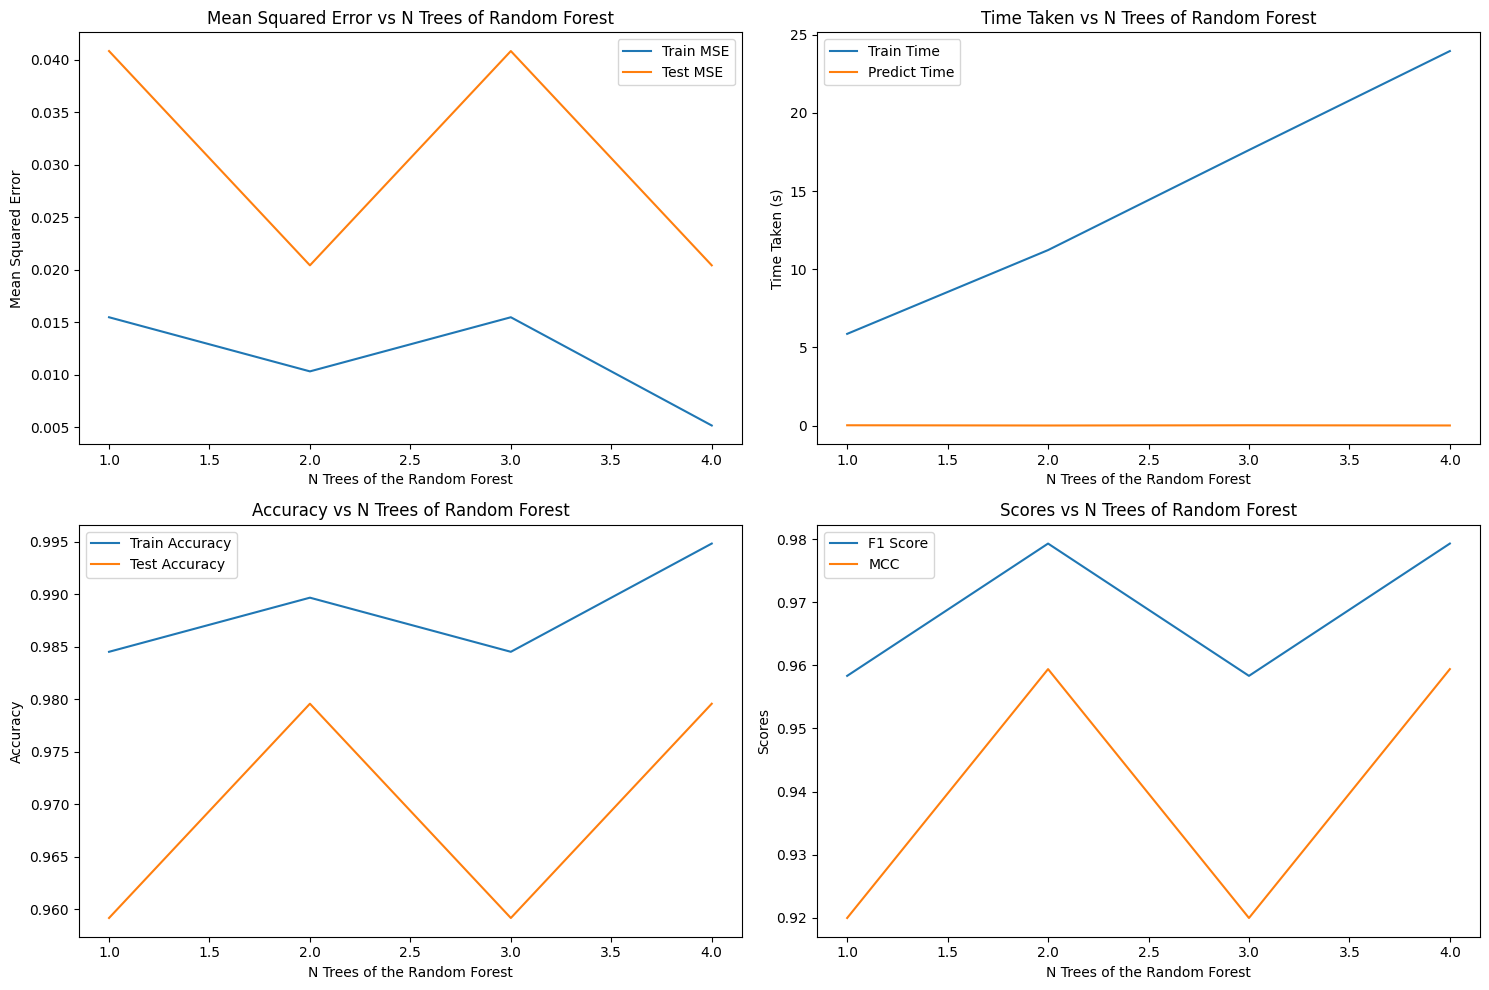

In [23]:
# Plotting the metrics
plot_metrics(Metrics, type, 'N Trees')

In [24]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
type = 'classification'
n_classes = np.unique(Y_test)
Metrics = {}
for n_trees in range(1, 5):
    print(f"Random Forest of {n_trees} trees")

    # Defining the model for Decision Tree
    model = RandomForest(type=type, criterion='gini', n_trees=n_trees, min_samples=10, max_depth=5)
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, Y_pred)
    if type == 'classification':
        accuracy_train = accuracy(Y_train, Y_pred)
        print(f"Train Accuracy: {round(100*accuracy_train, 3)}")
    start = time()
    Y_pred = model.predict(X_test)
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test, Y_pred)
    if type == 'classification':
        accuracy_test = accuracy(Y_test, Y_pred)
        f1score = 0
        mcc = 0
        for i in range(len(n_classes)):
            f1score += F1_Score(Y_test, Y_pred, n_classes[i])
            mcc += MCC(Y_test, Y_pred, n_classes[i])
        f1score /= len(n_classes)
        mcc /= len(n_classes)
        print(f"Test Accuracy: {round(100*accuracy_test, 3)}")
        print(f"F1 Score: {round(f1score, 3)}")
        print(f"Matthews Correlation Coefficient: {round(mcc, 3)}")

    # Storing the metrics
    Metrics[n_trees] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    print(f"Train MSE: {round(train_mse, 3)}")
    print(f"Test MSE: {round(test_mse, 3)}")
    if type == 'classification':
        Metrics[n_trees]["Train Accuracy"] = accuracy_train
        Metrics[n_trees]["Test Accuracy"] = accuracy_test
        Metrics[n_trees]["F1 Score"] = f1score
        Metrics[n_trees]["MCC"] = mcc

    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T

Random Forest of 1 trees
Train Accuracy: 96.907
Test Accuracy: 95.918
F1 Score: 0.959
Matthews Correlation Coefficient: 0.918
Train MSE: 0.031
Test MSE: 0.041

------------------------------------------------------------

Random Forest of 2 trees
Train Accuracy: 97.938
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.96
Train MSE: 0.021
Test MSE: 0.02

------------------------------------------------------------

Random Forest of 3 trees
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------

Random Forest of 4 trees
Train Accuracy: 98.969
Test Accuracy: 97.959
F1 Score: 0.979
Matthews Correlation Coefficient: 0.959
Train MSE: 0.01
Test MSE: 0.02

------------------------------------------------------------



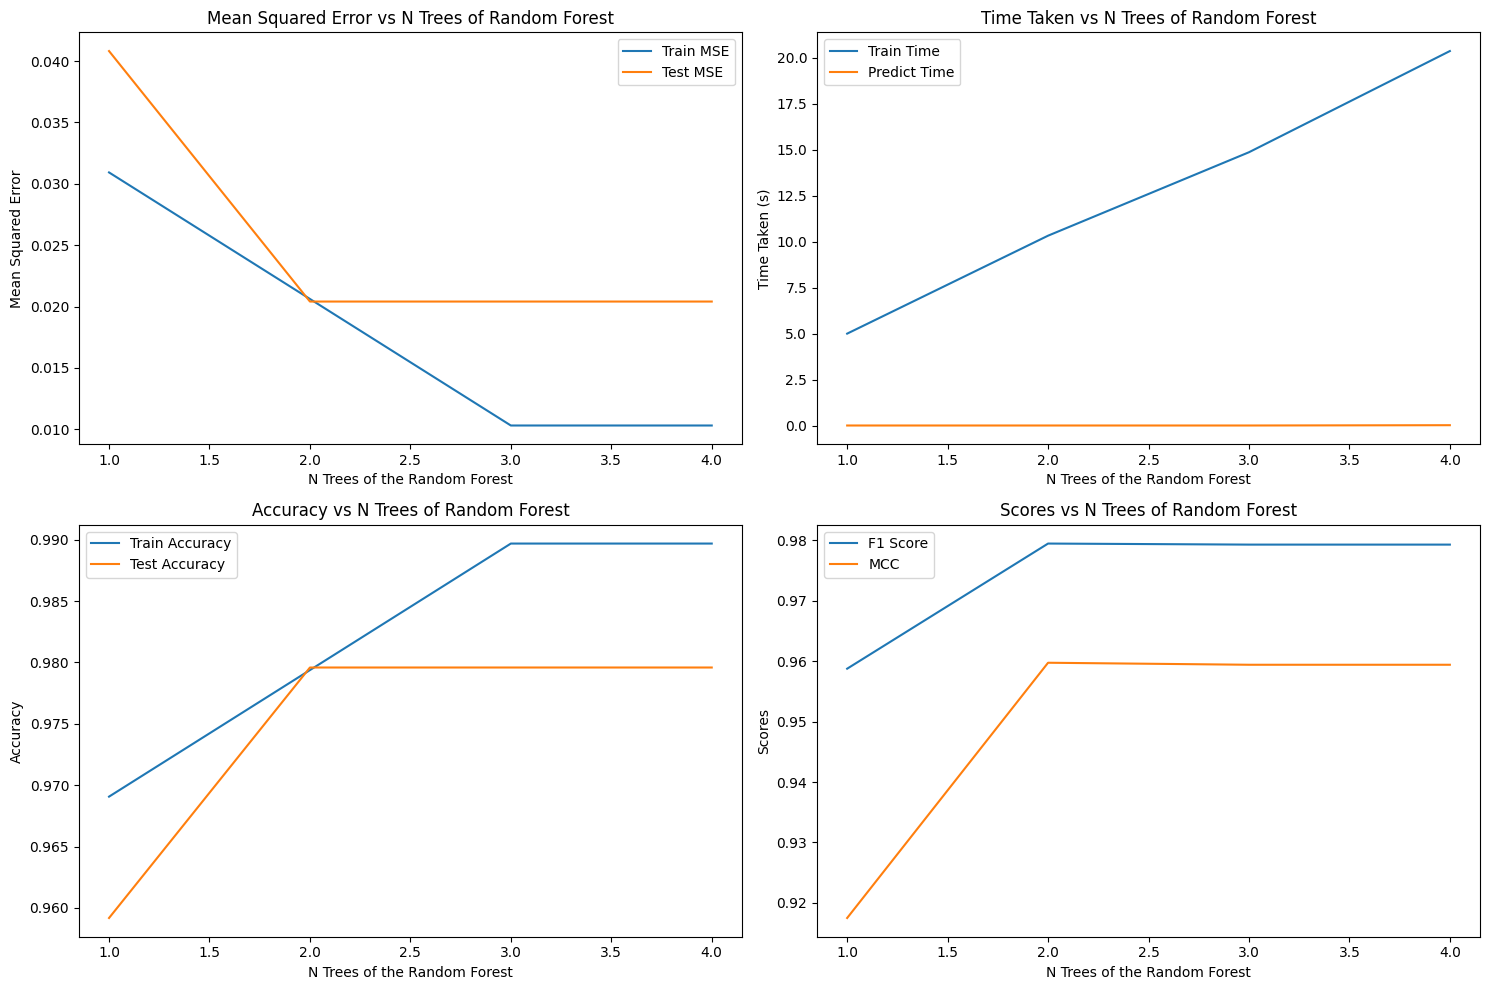

In [25]:
# Plotting the metrics
plot_metrics(Metrics, type, 'N Trees')

### Generating and Saving Models

In [26]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
type = 'classification'
for depth in range(0, 6):
    for n_trees in range(1, 6):
        for criterion in ['Entropy', 'Gini']:
            print(f"Random Forest of {n_trees} trees, depth {depth}, and criterion {criterion}")

            # Defining the model for Decision Tree
            model = RandomForest(type=type, criterion=criterion.lower(), n_trees=n_trees, min_samples=10, max_depth=depth)
            model.fit(X_train, Y_train)

            # Saving the model
            filepath = os.path.join(directory, f"RForest_{criterion}_{n_trees}_{depth}.pkl")
            with open(filepath, "wb") as file:
                pickle.dump(model, file)
            print("\n------------------------------------------------------------\n")

Random Forest of 1 trees, depth 0, and criterion Entropy

------------------------------------------------------------

Random Forest of 1 trees, depth 0, and criterion Gini

------------------------------------------------------------

Random Forest of 2 trees, depth 0, and criterion Entropy

------------------------------------------------------------

Random Forest of 2 trees, depth 0, and criterion Gini

------------------------------------------------------------

Random Forest of 3 trees, depth 0, and criterion Entropy

------------------------------------------------------------

Random Forest of 3 trees, depth 0, and criterion Gini

------------------------------------------------------------

Random Forest of 4 trees, depth 0, and criterion Entropy

------------------------------------------------------------

Random Forest of 4 trees, depth 0, and criterion Gini

------------------------------------------------------------

Random Forest of 5 trees, depth 0, and criterion Ent